<a href="https://colab.research.google.com/github/mcnica89/MATH4060/blob/main/Project1_Sample_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import packages. Feel free to add any others you might use!
import itertools
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random as jrandom
from jax import nn as jnn
import random
import time
import math
import numpy as np
import sympy

# Problem 1 - Simulating a Markov chain with uniform random variables (Solution from Alison Siaw & Sam Vermeulen)

The probability that a uniform random variable will be in between intervals generated by a cumulative sum of a probability vector is the probability of transitioning between states.

For example: If we have the probability vector  [0.3,0.2,0.5] . The cumulative sum vector will be  [0.3,0.5,1.0] . Then a uniform random variable in the interval  [0,1] . Has  0.3  probability to be in the interval  [0.0,0.3] , a  0.2  probability to be in the interval  [0.3,0.5] , and a  0.5  probability to be in the interval  [0.5,1.0] . In these cases we would transition to states 0, 1, or 2 respectively.

In [2]:
def Markov_chain_sim(P,X_0,U, tests=False):
  '''Given X_0 and the transition matrix P, gives a possible X_1 
     using a uniform [0,1] random variable'''
  #Input: 
  #  P = An array of shape (N,N) where the entries are non-negative and each row sums to 1  
  #  x_0 = An integer from the state space [0,N-1]
  #  U = A real number between [0,1] which is generated as a uniform random variable
  #Ouput:
  #  An integer from the state space [0,N-1] which gives the location of the Markov chain at time X_1

  # note: this function can also take in an array of uniform random variables and will return an array of X_1's

  if tests:
    assert(np.all(np.sum(P,axis=1) == 1))

  # searchsorted is used to find indicdes in a sorted array such that the order of the original array would still be preserved
  # position is assigned to searchsorted passing the sorted cumulative sum and random variable U as parameter

  # the cumulative sum of the transitions from state X_0
  transition_cumsum = np.cumsum(P[X_0])

  # finds the position in the transition_cumsum that the random variable U should
  # be placed to maintain the order. This is the state we should transition to.
  position = np.searchsorted(transition_cumsum, U)

  # return the position(s) in the array to the left where random variable(s) U should be inserted
  return position


## Problem 1 - Tests

These are just tests we performed while working on this problem.

In [3]:
def test_Markov_chain_sim_distribution(transition_matrix, num_runs):
  #Purpose:
  # Used to visually check the distribution of the Markov chain simulation
  #Input:
  # transition_matrix - the test matrix
  # num_runs - the number of simulations to run on each state of the transition_matrix
  # print_transition_matrix - flag tells function to display the transition matrix 

  print("Expected Distribution:\n", transition_matrix*num_runs)

  results = np.zeros(transition_matrix.shape)
  for i in range(len(transition_matrix[0])):
    (uq, counts) = np.unique(Markov_chain_sim(transition_matrix, i, np.random.uniform(size=num_runs)), return_counts=True)
    results[i][uq] = counts

  print("\nResults:\n", results)

def test_Markov_chain_sim_choices():
  transition_matrix = np.array([[0.3, 0.2, 0.5],
                                [0.1, 0.4, 0.5],
                                [0, 1, 0.0]])


  assert(Markov_chain_sim(transition_matrix, 0, 0.8, tests=True) == 2)
  assert(Markov_chain_sim(transition_matrix, 0, 0.001, tests=True) == 0)

  assert(Markov_chain_sim(transition_matrix, 1, 0, tests=True) == 0)
  assert(Markov_chain_sim(transition_matrix, 1, 0.5, tests=True) == 1)
  assert(Markov_chain_sim(transition_matrix, 1, 0.8, tests=True) == 2)

  assert(Markov_chain_sim(transition_matrix, 2, 0.001, tests=True) == 1)
  assert(Markov_chain_sim(transition_matrix, 2, 0.5, tests=True) == 1)
  assert(Markov_chain_sim(transition_matrix, 2, 0.999, tests=True) == 1)

%time test_Markov_chain_sim_distribution(jnp.array([[0, 0.25, 0, 0, 0.75], [0, 0.1, 0, 0, 0.9], [0.4, 0, 0, 0, 0.6], [0, 0, 0.5, 0.5, 0], [0, 0, 0.3, 0.7, 0]]), 10_000_000)

test_Markov_chain_sim_choices()

Expected Distribution:
 [[      0. 2500000.       0.       0. 7500000.]
 [      0. 1000000.       0.       0. 9000000.]
 [4000000.       0.       0.       0. 6000000.]
 [      0.       0. 5000000. 5000000.       0.]
 [      0.       0. 3000000. 7000000.       0.]]

Results:
 [[      0. 2499752.       0.       0. 7500248.]
 [      0.  999525.       0.       0. 9000475.]
 [3999705.       0.       0.       0. 6000295.]
 [      0.       0. 5000824. 4999176.       0.]
 [      0.       0. 2997223. 7002777.       0.]]
CPU times: user 4.28 s, sys: 200 ms, total: 4.48 s
Wall time: 5.34 s


# Problem 2 - A weather model (solution by Rob Proner and Jordan Areias)

## 2a Solution

The weather on any given day is not a Markov process. However, we can transform it into one by defining the appropriate state space. Let $\{X_n\}$, n= 0, 1, 2, ..., be a Markov process with the state space $S = \{\text{Sunny today and yesterday, Sunny today but rainy yesterday, Rainy three days in a row, Rainy two days in a row (but not rainy three days in a row), Rainy today (but not rainy two days in a row)}\}$ and probability transition matrix $\mathbf{P}$ given by

$$ \mathbf{P} = 
\begin{bmatrix} 
  0.5 & 0 & 0 & 0 & 0.5 \\
  0.7 & 0 & 0 & 0 & 0.3 \\
  0 & 0.9 & 0.1 & 0 & 0 \\
  0 & 0.75 & 0.25 & 0 & 0 \\
  0 & 0.6 & 0 & 0.4 & 0
\end{bmatrix}
$$

We can represent this Markov chain by the directed graph depicted below. The 8 possible combinations of weather for the last three days, $\{RRR,RRS,RSR,RSS,SRR,SRS,SSR,SSS\}$ are grouped into the 5 states we defined for the statespace $S$.
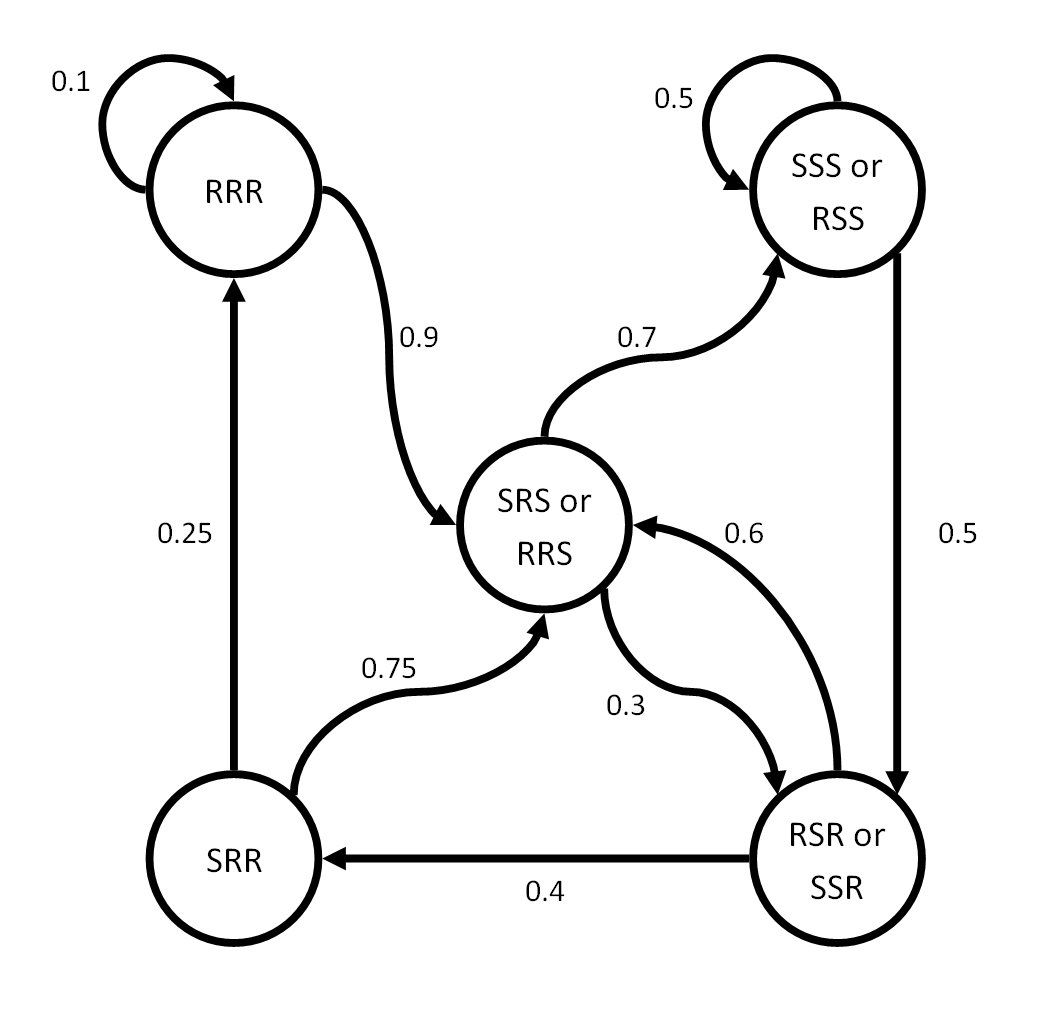

#### Figure 1: Directed graph representation of weather model Markov Chain

## 2b Solution

For any $n \in \mathbb{N}$, the $nth$ day probability vector $\mathbf{v}_n$ is given by
$$
\mathbf{v}_n = \mathbf{v}_0 ⋅ \mathbf{P}
$$
Where $\mathbf{v}_0$ is the initial state vector and $\mathbf{P}$ is the transition probability matrix.


In [4]:

def rainy_probability(n):
  #Purpose: Find the exact probability on day n given that is sunny today and sunny yesterday
  # -------------------
  #Input: 
  #  n = integer number of days in the future
  #Output:
  # A single number which is the probabaility it is rainy on day n
  # -------------------

  
  # Initial state vector
  v0 = jnp.array([1., 0., 0., 0., 0.])

  # Transition matrix
  P = jnp.array([[0.5, 0., 0., 0., 0.5],
                [0.7, 0., 0., 0., 0.3],
                [0., 0.9, 0.1, 0., 0.],
                [0, 0.75, 0.25, 0., 0.],
                [0., 0.6, 0., 0.4, 0.]])

  # Probability vector for day n
  vn = jnp.matmul(v0, jnp.linalg.matrix_power(P, n))
  
  # It is rainy in the last three states so we sum their probabilites to get the probability of rain on day n
  pRain = vn[2:].sum()

  return float(pRain) 

### Tests and plots for 2b

In [5]:
# Prints probability of sun 7 days from two consecutive rainy days

print(f"The probability of it being rainy on day 7 is: {rainy_probability(7)}")

The probability of it being rainy on day 7 is: 0.3853685259819031


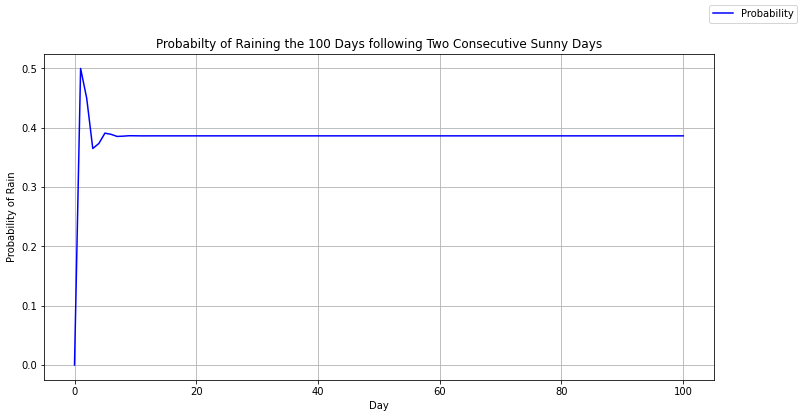

In [6]:
# Creates a plot of the probability of raining the 100 days following two consecutive sunny days
# Number of days to compute
N = 100
# Creates an array of different rain probabilities
probs = jnp.array([rainy_probability(n) for n in range(N+1)])

# Creates a plot
fig, ax = plt.subplots()

ax.set_title("Probabilty of Raining the 100 Days following Two Consecutive Sunny Days")
ax.set_ylabel("Probability of Rain")
ax.set_xlabel("Day")
ax.plot(jnp.arange(0,N+1), probs, "blue")
ax.xaxis.grid()
ax.yaxis.grid()

fig.set_size_inches(12, 6)
fig.legend(["Probability"])
plt.show()

## 2c Solution


Every Markov chain has a stationary distribution which satisfies

$$
\mathbf{v}_\infty = \mathbf{v}_\infty \cdot \mathbf{\text{P}} 
$$

where $\mathbf{v}_\infty = \lim_{n \to \infty} \mathbf{v}_n = \lim_{n \to \infty} \mathbf{v}_0 \cdot \mathbf{\text{P}}^n$
\begin{align}
  [p_1, p_2, p_3, p_4, p_5] &= [p_1, p_2, p_3, p_4, p_5] \begin{bmatrix}
  0.5 & 0 & 0 & 0 & 0.5 \\
  0.7 & 0 & 0 & 0 & 0.3 \\
  0 & 0.9 & 0.1 & 0 & 0 \\
  0 & 0.75 & 0.25 & 0 & 0 \\
  0 & 0.6 & 0 & 0.4 & 0
\end{bmatrix}
\end{align}

 Thus we have five equations in five unknowns
\begin{align}
0.5p_1 + 0.7p_2 &= p_1 \implies -0.5p_1 + 0.7p_2 &= 0 \qquad (1)\\
0.9p_3 + 0.75p_4 + 0.6p_5 &= p_2 \implies -p_2 + 0.9p_3 + 0.75p_4 + 0.6p_5 & = 0\qquad (2) \\
0.1p_3 + 0.25p_4 &= p_3 \implies -0.9p_3 +0.25p_4 &= 0 \qquad (3) \\
0.4p_5 &= p_4 \implies -p_4 + 0.4p_5 &= 0 \qquad (4)\\
0.5p_1 + 0.3p_2 &= p_5 \implies 0.5p_1 + 0.3p_2 - p_5 &= 0\qquad (5)
\end{align}

And so we have the form $\text{A}\mathbf{x} = \mathbf{b}$ where 
$$\text{A} = \begin{bmatrix}
-0.5 & 0.7 & 0 & 0 & 0\\
0 & -1 & 0.9 & 0.75 & 0.6\\
0 & 0 & -0.9 & 0.25 & 0\\
0 & 0 & 0 & -1 & 0.4\\
0.5 & 0.3 & 0 & 0 & -1\\
\end{bmatrix};
\qquad\mathbf{x}= [p_1, p_2, p_3, p_4, p_5];
\qquad\mathbf{b} = \mathbf{0}
$$

After row reducing we find we have a redundant row.

In [7]:
#Purpose: Find the exact limiting probability it is rainy in the far future
#Output: 
# A single number which is the value of the limit

A = sympy.Matrix([[-0.5, 0.7, 0., 0., 0.],
            [0., -1., 0.9, 0.75, 0.6],
            [0., 0., -0.9, 0.25, 0.],
            [0, 0., 0., -1., 0.4],
            [0.5, 0.3, 0., 0., -1.]])

# Returns RREF form of matrix A
print(f"P in row reduced echelon form is: {A.rref()}")

P in row reduced echelon form is: (Matrix([
[1,   0,   0, 0,               -1.4],
[0,   1,   0, 0,               -1.0],
[0,   0,   1, 0, -0.111111111111111],
[0, 0.0, 0.0, 1,               -0.4],
[0,   0,   0, 0,                  0]]), (0, 1, 2, 3))


After row reduction we have
$$ \begin{bmatrix}
0 \\ 0 \\ 0 \\ 0 \\ 0
\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0 & 0 & -1.4 \\
0 & 1 & 0 & 0 & -1 \\
0 & 0 & 1 & 0 & -\frac{1}{9} \\
0 & 0 & 0 & 1 & -0.4 \\
0 & 0 & 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix} p_1 \\ p_2 \\ p_3 \\ p_4 \\ p_5 \end{bmatrix}
 $$

This matrix is degenerate and thus not invertible. However, realizing that we require $p_1 + p_2 + .. + p_5 = 1$ we can modify this equality like so


$$ \begin{bmatrix}
0 \\ 0 \\ 0 \\ 0 \\ 1
\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0 & 0 & -1.4 \\
0 & 1 & 0 & 0 & -1 \\
0 & 0 & 1 & 0 & -\frac{1}{9} \\
0 & 0 & 0 & 1 & -0.4 \\
1 & 1 & 1 & 1 & 1
\end{bmatrix}
\begin{bmatrix} p_1 \\ p_2 \\ p_3 \\ p_4 \\ p_5 \end{bmatrix}
 $$

 Now, we can solve for our limiting distribution

In [8]:
def limit_rainy_probability():
  #Purpose: Find the exact limiting probability it is rainy in the far future
  #Output: 
  # A single number which is the value of the limit

  #Defines jnp array A as described above
  A = jnp.array([[1., 0., 0., 0., -1.4],
            [0., 1., 0., 0., -1],
            [0., 0., 1., 0., -0.11],
            [0, 0., 0., 1., -0.4],
            [1., 1., 1., 1., 1.]])

  #Defines jnp array vector, b, as a zero vector with a 1 in the last row
  b = jnp.array([0., 0., 0., 0., 1.])

  #Solves for [p1, p2, p3, p4, p5] using A and b
  v_infty = jnp.linalg.solve(A, b)

  #Sums the states where it is rainy
  pRain_long_term = v_infty[2:].sum()

  return pRain_long_term

In [9]:
print(f"The long term probability of a rainy day in this Markov chain is:\n{limit_rainy_probability()}")

The long term probability of a rainy day in this Markov chain is:
0.3861892819404602


#Problem 3 - Monkey at a typewriter 

## 3a Solution (solution from Alison Siaw & Sam Vermeulen)

Using this as a Markov Chain would be difficult for the computer to handle because the state space of the problem would be $n_{buttons}^{n_{word}}$. This state space will grow extremely fast as $n_{buttons}$ or $n_{word}$ grows.

## 3b Solution (solution in 3bcd by Rob Proner and Jordan Areias)

Consider using the state space of subsequences of words starting with the first button in the given **word sequence** $\vec{w}$ and one other state that represents the monkey pressing a button that is not the next button in the **word sequence**.

**For example**, if our **word sequence** is **012** and we have 4 buttons $(0, 1, 2, 3)$. Our state space would be as follows:

\begin{align*}
  \mathcal{S} = \{0, 01, 012, \text{'not in sequence'}\}
\end{align*}

Let $X_t$ be the state at time t, then the transition probability are as follows:

* $\mathbb{P}(X_t = 0 | X_{t-1} = \text{NIS}) = \frac{1}{4}$
* $\mathbb{P}(X_t = \text{NIS} | X_{t-1} = \text{NIS}) = \frac{3}{4}$
* $\mathbb{P}(X_t = 01 | X_{t-1} = 0) = \frac{1}{4}$
* $\mathbb{P}(X_t = \text{NIS} | X_{t-1} = 0) = \frac{2}{4}$
* $\mathbb{P}(X_t = 0 | X_{t-1} = 0) = \frac{1}{4}$
* $\mathbb{P}(X_t = 012 | X_{t-1} = 01) = \frac{1}{4}$
* $\mathbb{P}(X_t = \text{NIS} | X_{t-1} = 01) = \frac{2}{4}$
* $\mathbb{P}(X_t = 0 | X_{t-1} = 01) = \frac{1}{4}$

Note: All other transitions are probability $0$, and $012$ is a terminal state

##3c Solution

Consider the model from 3b and let $n_{buttons} = 6$. Then, $\{X_n\}$ is a Markov chain with states $(0, 1, ..., n_{word})$, where $n_{word}$ is the length of the word. Let's consider the naive case where we are given a word that is  letters long and none of those letters repeat. In this case,transition probabilities are outlined as follows: \
$$
P_{i0} = \frac{5}{6}, i∈(0, 1,...,n_{word}-1);
$$

$$
P_{i1} = \frac{1}{6}, i∈(0, 1,...,n_{word}-1);
$$

$$
P_{i, i+1}= \frac{1}{6}, i\in(0, ..., n_{word}-1);
$$

$$
P_{n_{word},0} = 0;\ P_{n_{word},n_{word}}=1
$$

In this case, the P would be defined as follows.

$$
  P = 
  \begin{pmatrix}
    5/6 & 1/6 & 0 & 0 & 0 & 0 & 0\\
    4/6 & 1/6 & 1/6 & 0 & 0 & 0 & 0\\
    4/6 & 1/6 & 0 &1/6 & 0 & 0  & 0\\
    4/6 & 1/6 & 0 & 0 & 1/6 & 0 & 0\\
    4/6 & 1/6 & 0 & 0 & 0 & 1/6 & 0\\
    4/6 & 1/6 & 0 & 0 & 0 & 0 & 1/6\\
    0 & 0 & 0 & 0 & 0 & 0 & 1 \\
  \end{pmatrix}
$$


where we make no progress ($P_{00}$) or lose progress ($P_{i,0}, i=0,...,5$) with probability $5/6$ and given $i$, the number of letters into the word, we get one additional letter with probability $1/6$, and move back to the first letter with a probability of $1/6$. Once all $6$ letters are collected, we stop, so the probability that we stay in state $6$ is $1$.

For more complex cases, we will not have the same format of contents in our $P$ matrix, as there are cases where we cannot return to the first letter (if the second letter is a repetition of the first letter) and cases where the first letter repeats later in the word. 

Let's consider the simple case of the sequence "0,1". Then $X_n$ is a random variable with states 0, 1, 2, since we are either, 0, 1, or 2 letters in, and transition probability matrix

$$
  P = 
  \begin{pmatrix}
    5/6 & 1/6 & 0\\
    4/6 & 1/6 & 1/6\\
    0 & 0 & 1\\
  \end{pmatrix}
$$

Notice that if we already have "0", then with $p=1/6$ we stay one letter in if we get another "0".

Now consider the sequence "0,0". $X_n$ is a r.v. with states 0, 1, 2, and transition probability matrix

$$
  P = 
  \begin{pmatrix}
    5/6 & 1/6 & 0\\
    5/6 & 0 & 1/6\\
    0 & 0 & 1\\
  \end{pmatrix}
$$

Now there is no possiblilty of staying at 1 letter in. Either we lose all progress or we get two letters. The directed graphs of these two Markov chains are shown below.


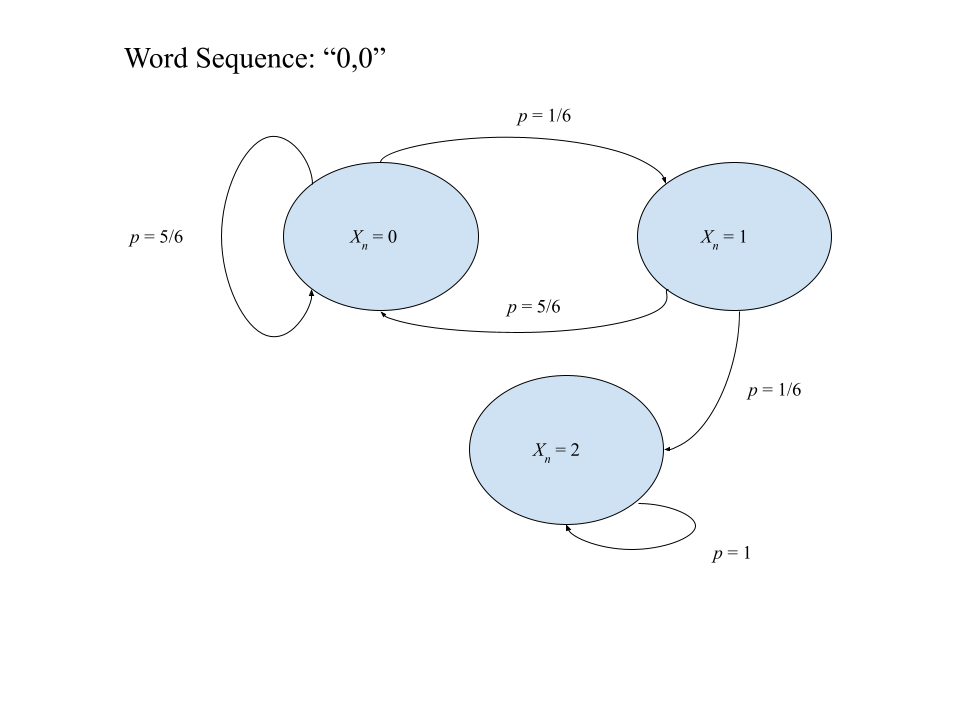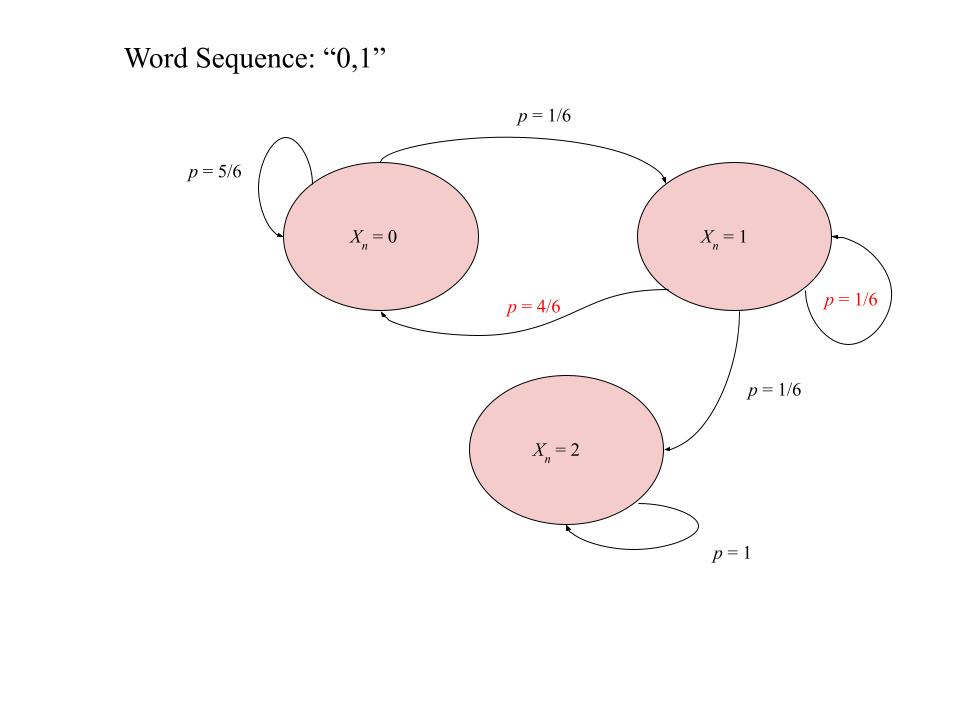

*From* the above directed graphs, intuition tells us that the sequence "0,1", will take fewer transitions, on average, than the sequence "0,0", since in the former sequence, if we have progressed one letter into the word, then one sixth of the time we will maintain our progress of one letter into the word, symbolically $P_{1,1} = 1/6$, whereas in the Markov chain for "0,0", we can only regress to 0 letters in or complete the sequence. \

## 3d Solution

### Assumptions

The $P$ matrix will prioritize moving towards the state with the greatest number of charecters typed. This is relevent if there is a repeated charecter/string.

### Explination of Code

Let $N = \min\{n\geq n_{word} : X_{n-n_{word}} = l_1, X_{n-n_{word} + 1} = l_2, ..., X_{n-1} = l_{n_{word} - 1}, X_n = l_{n_{word}}\}$ be the number of transitions needed to complete a word of length $n_{word}$. We seek

$$
  E[N|X_0 = 0]
$$

$$
t(i) = E[N|X_0 = i]
$$
we want
$$
  t(0) = E[N | X_0 = 0]
$$

$$
  t(0) = E[t(X_1) | X_0 = 0] + 1
$$

Let 
$$
  t = [t(0), t(1), ..., t(n_{word}-1)]
$$

Where $t$ is the solution to 

$$
  (I - P)t = v = \begin{bmatrix}
  1 \\
  1\\
  \vdots \\
  1\\
  0
  \end{bmatrix}
$$

### Note on constructing the P matrix

Given that there is not a consistent set of rules to create the structure of the P Matrix, an algorithm is required. The algorithm detailed below will consider a $P$ matrix where for each element in columns 1 to $(n_{word}+1)$. It will consider the elements location where $P_{i,j}$ to test if appending the $j$th letter to sequence of the first $i$ terms creates the first $j$ terms at the end of the string. The algorithm will work from the right hand side to the left and every time a letter is successfully place, it will track this terms in a list of letters used thus far. If a letter has already been used withinin the $j$ row the algorith inspects, it will not be placed again in this row. This will ensure when appending the same letter to a string can send you to two states, the later state is prioritized. 

In [10]:
def array_append(array_1,array_2):
  #Purpose:
  #  Appends array_2 to the end of array_1 for zero dimension array
  #Input: 
  # array_1 = the big array
  # array_2 = the int number we want to add

  length = len(array_1)

  # Creates a placeholder array with an extra zero appended
  placeholder = jnp.zeros(length+1)

  #Moves array_1 into the placeholder
  for k in range(length):
    placeholder = placeholder.at[k].set(array_1[k])

  # Sets the final term of the placeholder array to the value of array_2
  placeholder = placeholder.at[length].set(array_2)

  return placeholder

In [11]:
 # NOTE: The code block above MUST be run for this function to work, since it depends on the append() function above.
 def expected_monkey_time(N_buttons, word_sequence):
  #Purpose:
  #   Returns the expected amount of time for the monkey to type the word
  #Input: 
  #  N_buttons = An integer, number of buttons on the typewritter
  #  word_sequence = An array of shape (N_word,). Each enty is an integer in [0,N_buttons-1]
  #Output:
  #  A real number which is the expected time until the word appears

  # Defining terms that will be used
  length = len(word_sequence) 
  matrix_size = length+1 #Defines Matrix Size based on length of word sequence
  alpha = (1/N_buttons) #Probability of hitting a button

  # Initializing Matrices
  P = jnp.zeros((matrix_size, matrix_size)) #
  I = jnp.eye(matrix_size,matrix_size) #
  V = (1)*jnp.ones((matrix_size,1)) # Creates a 


  #For loop to check if appending the next letter will make the next state
  for i in range(0,length):
    # Defines used list of used letters
    used_letters = []
    # For loop iterating over every column starting RHS and shifting left
    for j in range(matrix_size,1,-1):
      # Defines what the new word that is formed appending first i letters and the jth letter
      new_word = array_append(word_sequence[:i],word_sequence[j-2])
      # Checks if the lengths are the same
      if (len(new_word[-(j-1):])==len(word_sequence[:(j-1)])):
        # Checks if the most recent term is in the new word equal the jth 
        # word sequence
        if (new_word[-(j-1):]==word_sequence[:(j-1)]).all():
          # Checks if the new letter being placed was already used
          if (word_sequence[j-2]) not in used_letters:
            # If not, appends this letter to used letters
            used_letters = array_append(used_letters,word_sequence[j-2])
            #Sets this element in the P Matrix equal to alpha
            P = P.at[i,j-1].set(alpha)

  # Defining final row, since you can only move forward
  P = P.at[length,length].set(1)
  
  # Defining first column as 1-(probability of moving to state other than 0)
  for i in range(matrix_size):
    sum = P[i, 1:].sum()
    P = P.at[i,0].set(1-sum)

  # Creating I-P
  I_P = (I-P)

  # Applying rule that at the final state there will be no further movements
  V = V.at[length,0].set(0)
  I_P = I_P.at[length,length].set(1)
  
  #Solves the (I-P)t = V matrix to find various expected times
  T = jnp.linalg.solve(I_P,V)

  #Define expected time to complete word starting with zero letters and rounds the number to nearest whole integer
  time_from_zero = round(T[0],0)
  return time_from_zero

In [12]:
# Test case for [0, 0] and [0, 1]

#Prints the expected time for [0, 1] and [0, 0] respectively
print(f"Given the sequence [0., 1.], the expected time is {expected_monkey_time(6,jnp.array([0, 1]))}")
print(f"Given the sequence [0., 0.], the expected time is {expected_monkey_time(6,jnp.array([0, 0]))}")
print("This follows with the trend predicted previously.")

Given the sequence [0., 1.], the expected time is [36.]
Given the sequence [0., 0.], the expected time is [42.]
This follows with the trend predicted previously.


In [13]:
def monkey_time_test(word_as_list, true_answer):
  found_answer = expected_monkey_time(5,jnp.array(word_as_list))
  if jnp.isclose(found_answer, true_answer)==True: 
    print( "Test passed!")
    return 1
  else:
    print( "Test failed!" )
    print( found_answer, " vs ", true_answer)
    return 0

def expected_monkey_time_tests():
  score = 0
  score += monkey_time_test([0], 5 )
  score += monkey_time_test([0,0], 30 )
  score += monkey_time_test([0,1], 25 )
  score += monkey_time_test([0,0,0], 155 )
  score += monkey_time_test([0,1,0], 130 )
  score += monkey_time_test([0,0,1], 125 )
  score += monkey_time_test([0,1,1], 125 )
  return int(score)/7 * 100

expected_monkey_time_tests()

Test passed!
Test passed!
Test passed!
Test passed!
Test passed!
Test passed!
Test passed!


100.0

# Problem 4 - Generalized PIG (Solution by Rylee 


## 4a Solution 

Let M be the gain if we decide to roll again. Then since we roll an $i$ with probability $p_i$, we have:
\begin{equation}
  \mathbb{E}[M]= \sum_{i=0}^{n_{max}}p_i i
\end{equation}

The optimal value $s^*$ can be found where the expected gain if we decide to roll again is exactly equal to $s^*$:
\begin{equation}
  s^* = P(\text{Don't bust})(s^* + \mathbb{E}[M]) \\
  s^* = (1 - p_{bust})(s^* + \mathbb{E}[M]) \\
  s^* - (1 - p_{bust})s^* = (1 - p_{bust})\mathbb{E}[M] \\
  p_{bust}s^* = (1 - p_{bust})\mathbb{E}[M] \\
  s^* = \frac{(1 - p_{bust})\mathbb{E}[M]}{p_{bust}},
\end{equation}

which in classic PIG yields the value of $s^\ast = 20$. Playing PIG always using the strategy to stop at $s^*$ is not ideal; if you are at $s^*$ but an additional roll could cause you to win the game, it is better to take the risk from an additional roll as opposed to giving your opponent the possibility of winning on the next turn. Similarily, if you are at $s^*$ and still significantly behind your opponent, it is better to take the risks from additional rolls to try and catch up.


## 4b Solution
Setting up the Markov chain $\{Y_n, n \geq 0\}$ to contain $s + n_{max} + 1$ states where $s$ is the target score. We use the state space $\{-1,0,1,\ldots,s+n_{max}-1\}$ where the states mean:

$Y_n = -1$ if we went bust (terminal state)

$Y_n = 0$ if this is the start of the turn

$Y_n = 1$ if we've advanced 1 this turn ($\sum X_n = 1$)

$\ldots$

$Y_n = s$ if we've advanced $s$ this turn ($\sum X_n = s$) (terminal state)

$\ldots$

$Y_n = s + n_{max} - 1 $ if we've advanced $s + n_{max} - 1$ this turn ($\sum X_n = s + n_{max} - 1$) (terminal state)

Employing this strategy means we roll at most $s$ times. Hence, the probability of busting can be found through the matrix $P^s$. With $\mathbf{p}$ as the probability vector over each state after rolling $s$ times (obtained by multiplying the original state by $P^s$), the expected value of this strategy can be found as $E[X]=\sum_{i=0}^{s + n_{max}} p_i m_i$, where $m_i$ is the score gained for state $i$.

In [14]:
import numpy as np
def generalized_pig_E_and_P(target_score,p_bust,v_advance):
  #Purpose:
  #  Returns the expected value of playing the startegy of re-rolling until you hit target_score in generlized Pig
  #Input:
  #  target_score = Integer
  #  p_bust = real in (0,1), probability to go bust on any given roll
  #  v_advance = an array of shape (N_max,) indicating the probability to advance on a non-bust roll

  n_max = len(v_advance)
  num_states = n_max + target_score
  P = initialize_transition_matrix(n_max, num_states, p_bust, v_advance)

  states = np.zeros(num_states)
  states[1] = 1 # Start in state corresponding to zero points gained
  probs = np.dot(states, np.linalg.matrix_power(P, target_score)) # Compute probabilities after rolling target_score times

  exp = compute_expectation(probs[1: ]) # Exclude probability of busting in computation

  return exp, probs[0] # Wasn't really sure what "probability to go bust at any time" meant. Simply returned probability
  # of busting on a given turn using this strategy


def initialize_transition_matrix(n_max, num_states, p_bust, v_advance):
  #Returns the transition matrix for the Markov chain
  P = np.zeros((num_states, num_states))
  P[0, 0] = 1 # Busting is a terminal state
  P[1:-n_max + 1, 0] = p_bust # Fill in bust probability for all other states

  # Fill in the terminal states for being >= target_score
  np.fill_diagonal(P[-n_max + 1:, -n_max + 1:], 1)

  # With the way the question is set up we need to normalize the v_advance
  # vector such that the rows of the matrix sum to one
  normalization = 1 - p_bust
  normalized_v_advance = (normalization * v_advance)  
  for row_ix, row in enumerate(P[1: -n_max + 1]):
    # We can advance [1, n_max] on any turn (with given probabilities)
    start_ix = row_ix + 1
    end_ix = start_ix + n_max
    row[start_ix: end_ix] = normalized_v_advance

  return P

def compute_expectation(probs):
  """Computes expected return for each turn given the probability 
  distribution (excluding p_bust)"""
  scores = np.arange(len(probs))
  return (scores * probs).sum()

# Problem 5 - Simple Can't Stop Roll Again AI 

## 5a Solution (solution by Theodore Oskroba and Valeria Telles)

We start off by calculating the current number of runners in play using ```count_nonzero()```. Then we check if we have reached the max number of runners, and if we have, then we calculate the probability to bust using the given function ```prob_to_miss_targets()``` along with the runner_col array and return this value. Otherwise we calculate the probability to bust using the same function, but we pass the result of a ```jnp.logical_or()``` operation using the runner_col array and the inverse of the illegal_col array. The resulting array will be of all legal/playable columns for runners. Finally, we return the resulting probability from the function.

In [15]:
def prob_to_miss_targets(targets):
  '''Compute the probability to miss a list of target cols'''
  #Input:
  #  targets = a boolean array of shape (11,) with which are targets
  #Output:
  #  A real number with the probability to miss all the targets from targets when rolling 4 dice and pairing them

  #Create an array of shape (4,6,6,6,6) that contains all possible dice rolls
  #  i.e. the entry [:,a,b,c,d] = [a,b,c,d] is 4 dice rolls and a,b,c,d all run from 0 to 5
  four_dice_indices = jnp.indices((6,6,6,6)) 
 
  #Create an array with all 6 ways to choose 2 out of 4 dice
  #  Pairing 0 = choose dice 1 and dice 2
  #  Pairing 1 = choose dice 1 and dice 3 
  #  ... 
  #  Pairing 6 = choose dice 3 and dice 4
  pairing = jnp.array([[1,1,0,0],[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1],[0,0,1,1]])

  #Create an array of shape (6,6,6,6,6) which gives the value of the pairing 
  #  i.e. the (p,a,b,c,d) entry is the value of pairing p when the dice come up a,b,c,d
  four_dice_pairings = jnp.einsum("iabcd,ji->jabcd",four_dice_indices,pairing)
  
  #The same array, but of shape (6,6,6,6,11) now where it has been converted to a one hot encoding
  #  i.e. (p,a,b,c,d,:) is an array of shape (11,) with the one hot encoding of the pairing
  four_dice_pairings_one_hot = jnn.one_hot(four_dice_pairings,11)

  #A boolean array of shape (6,6,6,6,6)
  #  The (p,a,b,c,d) entry is k when the p-th pairing of a,b,c,d is hits the target list k times
  hit_target = jnp.einsum("pabcdk,k->pabcd",four_dice_pairings_one_hot,targets)

  #This is an array of shape (6,6,6,6) which is True when at least one of the pairings is in the target
  any_hit_target = jnp.any(hit_target > 0, axis=0)

  #Count the number of times we get a hit!
  number_of_dice_rolls_that_hit_target = jnp.count_nonzero(any_hit_target)

  #Convert count into a probability
  #  1296 = 6**4 is the total number of possible dice rolls
  return (1296- number_of_dice_rolls_that_hit_target)/1296

In [16]:
def cant_stop_bust_probability(runner_col,illegal_col):
  #Purpose:
  #  Compute the bust_probability if we were to roll again in Can't Stop
  #Input:
  #  runner_col = an array of shape (11,) of integers with the runner locations
  #  illegal_col = an array of shape (11,) of boolean with which columns are illegal to play in 
  #NOTE:
  #  We assume N_Max_Runners = 3 for this one!

  N_Max_Runners = 3

  num_runners = jnp.count_nonzero(runner_col) # calculate runners by counting non-zero indices

  if (num_runners >= N_Max_Runners): # if there are the max number of runner in play, calculate probability
    return prob_to_miss_targets(runner_col)

  b_prob = prob_to_miss_targets(jnp.logical_or(runner_col, 1-illegal_col)) # calculate the chance to miss playable columns
  return float(b_prob)

## 5b Solution (Soluton by Alison Siaw & Sam Vermeulen)

**Recall:** In question 4, we found the optimal score strategy for *Generalized Pig*. We are going to use a similar approach for a simple don't stop AI. We found that the optimal roll strategy is to stop rolling when the **expected score** is less than or equal to the **current score**.

This works great because there is only one column we need to worry about. However, in *Can't Stop* there are multiple columns. So rather than thinking about **current score** and **expected score**, we will consider the **current progress** and **expected progress**:

* **current progress** is the sum of the progress of each runner.
* **expected progress** is the expected sum of the progress of each runner if we roll again.

We choose to roll again if **current progress** $<$ **expected progress**, otherwise we choose to end our turn.

To calculate the expected score in *Generalized Pig* we used the following formula:

\begin{align}
  \mathbb{E}(X_t) = (1-p_{bust})(\mathbb{E}(\text{roll}) + X_{t-1})
\end{align}

Where $X_t$ is the **score** at time $t$, $p_{bust}$ is the probability to go bust on any given roll, and $\mathbb{E}(\text{roll})$ is the **expected score** gained from any given roll.  We will use this formula in our *Can't Stop* AI, modified slightly for **expected progress** at time $t$. 

Let $p_{bust}$ be probabilty we go bust on any given roll in *Can't Stop*, and $X_{t}$ be the **current progress** at time $t$. Then,

\begin{align}
  \mathbb{E}(\text{X}_t) = (1-p_{bust})(\mathbb{E}(\text{roll}) + \text{X}_{t-1}) \tag{1}
\end{align}

Where, $\mathbb{E}(\text{roll}) = γ(1-p_{bust})$, $\gamma \in [1,2]$. $\mathbb{E}(\text{roll})$ is the **expected progress gained** on any given roll.

Note: $\gamma$ is some constant that represents the amount of progress that is made if we do not bust. In the case that we don't bust then we either progress by 1 or 2. Thus, the expected $\gamma$ is somewhere in the interval $[1,2]$. We could calculate the true $\gamma$ given the **runner_col** and **illegal_col**. But to get a nice solution we are going to **assume** that $\gamma = 1.33$. We can change $\gamma$ to make the AI play passively or aggressively. 


Note from Prof Nica: A few students actually used the probability calculations to calculate the exact value of $\gamma$ depending on the position of the runners! Another strategy also maximized the **percentage** of the board progress, rather than the absolute number of squares being advanced (these are not the same because some columns have only 3 squares while some columns have 11 squares in "Can't Stop". So advancing one square in column 2 is more percentage than advancing one square in column 7, even if both are 1 square.)

In [17]:
def simple_roll_again_AI(runner_col, illegal_col, gamma=1.33, tests=False):
  #Purpose:
  #  Determine wheter or not to roll again or not in Can't stop given ONLY the current state of the runners and the illegal columns
  #  (Note: A better AI would take into account the player positions too, but we are making a very simple AI here)
  #Input:
  #  runner_col = an array of shape (11,) of integers with the runner locations
  #  illegal_col = an array of shape (11,) of boolean with which columns are illegal to play in 
  #NOTE:
  #  We assume N_Max_Runners = 3 for this one!

  # get the probability of bust
  p_bust = cant_stop_bust_probability(runner_col, illegal_col)

  # calculates the expected total progress after this roll as in equation (1)
  expt_prog = (1-p_bust)*(gamma*(1-p_bust) + np.sum(runner_col))

  # the total current progress made
  curr_prog = np.sum(runner_col)

  if tests:
    print("p_bust:", p_bust)
    print("expected:", expt_prog)
    print("current:", curr_prog)

  # if the expected progress after this roll is higher than the current progress
  # roll again! otherwise we stop rolling.
  if expt_prog > curr_prog:
    return 1
  else:
    return 0

simple_roll_again_AI(jnp.array([0, 0, 0, 0, 4, 0, 5, 0, 4, 0, 0]), jnp.array([0,0,0,0,0,0,0,0,0,0,0]), tests=True)

p_bust: 0.08873457
expected: 12.950889
current: 13


0

## Problem 5 - Tests
These are just some tests we did while working on this problem.

In [18]:
def test_simple_roll_again_AI():

  # is we only have 1 runner in play and there are no illegal
  # columns, our AI should always roll.
  for i in range(1000):
    assert(simple_roll_again_AI(jnp.array([0, 0, 0, 0, i, 0, 0, 0, 0, 0, 0]), jnp.array([0,0,0,0,0,0,0,0,0,0,0])) == 1)
  
  # if we have runners only in low probability columns we should probably stop rolling
  assert(simple_roll_again_AI(jnp.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]), jnp.array([0,0,0,0,0,0,0,0,0,0,0])) == 0)

  # if we have a 100% chance to bust we should probably stop rolling
  assert(simple_roll_again_AI(jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), jnp.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])) == 0)

  # if we have a 0% chance to bust we should probably keep rolling
  assert(simple_roll_again_AI(jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])) == 1)

test_simple_roll_again_AI()